# Fast Spectral Clustering using Connectivity as the criteria for the K-nearest neighbors

In [3]:
import numpy as np
import scipy.sparse.linalg
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import rbf_kernel
import stag.graph
import stag.stag_internal
import math
import time
import random
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score,adjusted_rand_score
from sklearn.decomposition import PCA

In [2]:
from typing import List, Set
import pickle
import time
import os.path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
from sklearn.metrics import normalized_mutual_info_score
from sklearn.neighbors import kneighbors_graph
from sklearn.datasets import fetch_openml
from scipy.spatial.distance import pdist, squareform
import stag.random
import stag.graph
import stag.cluster
import stag.graphio

In [51]:
# mnist = fetch_openml('har')

In [50]:
# mnist.data

In [52]:
# mnist.target

In [7]:
# y=mnist.target

In [8]:
# y.shape

In [4]:
def preprocess_openml_data_connectivity(dataset_name: str):
    # Load the graph
    mnist = fetch_openml(dataset_name)
    replace_dict = {chr(i): i-96 for i in range(97, 107)}
    X = np.array(mnist.data.replace(replace_dict))
    target_to_label = {}
    gt_labels = []
    next_label = 0
    for l in list(mnist.target):
        if l not in target_to_label:
            target_to_label[l] = next_label
            next_label += 1
        gt_labels.append(target_to_label[l])
    knn_graph = kneighbors_graph(X, n_neighbors=10, mode='connectivity',
                                 include_self=False)
    new_adj = scipy.sparse.lil_matrix(knn_graph.shape)
    for i, j in zip(*knn_graph.nonzero()):
        new_adj[i, j] = 1
        new_adj[j, i] = 1
        
    return new_adj,gt_labels    
#     with open(f"data/{dataset_name}.pickle", 'wb') as fout:
#         pickle.dump((new_adj, gt_labels), fout)
#     with open(f"data/{dataset_name}_data.pickle", 'wb') as fout:
#         pickle.dump(X, fout)

In [5]:
def fast_spectral_cluster(g: stag.graph.Graph, k: int, t_const=10):
    l = min(k, math.ceil(math.log(k, 2)))
    t = t_const * math.ceil(math.log(g.number_of_vertices() / k, 2))
    M = g.normalised_signless_laplacian()
    Y = np.random.normal(size=(g.number_of_vertices(), l))
    for _ in range(t):
        Y = M @ Y
    labels, cl_center = kmeans(Y, k)
    return labels,cl_center

In [6]:
def kmeans(data, k):
    """
    Apply the kmeans algorithm to the given data, and return the labels.
    """
    kmeans_obj = KMeans(n_clusters=k,n_init=1,init='random',max_iter=1000, tol=1e-5)
    kmeans_obj.fit(data)
    return [int(x) for x in list(kmeans_obj.labels_)], kmeans_obj.cluster_centers_

In [8]:
def main_program_fastc():
    mnist = fetch_openml('har')
    y=mnist.target
    start=time.time()
    adj,gt_labels=preprocess_openml_data_connectivity('har')
    g = stag.graph.Graph(adj)
    K=6
    y_pred,clu=fast_spectral_cluster(g,K)
    end=time.time()
    tot_time=end-start
    y_pred_adjusted = [label + 1 for label in y_pred]
    ari=adjusted_rand_score(y,y_pred_adjusted )
    nmi=normalized_mutual_info_score(y,y_pred_adjusted )
#     print("The adjusted_rand_score between the assigned clusters and the actual clusters: ")
#     print(ari)
#     print("The normalized_mutual_info_score between the assigned clusters and the actual clusters: ")
#     print(nmi)
    y1=y.tolist()
    y1=[int(num) for num in y1]
    return y_pred_adjusted,clu,mnist.data,y1,tot_time,ari,nmi

In [9]:
y_pred_1,clu_1,data_1,y_1,tot_time_1,ari_1,nmi_1=main_program_fastc()

In [10]:
print("The adjusted_rand_score between the assigned clusters and the actual clusters: ")
print(ari_1)
print("The normalized_mutual_info_score between the assigned clusters and the actual clusters: ")
print(nmi_1)

The adjusted_rand_score between the assigned clusters and the actual clusters: 
0.49170618201702704
The normalized_mutual_info_score between the assigned clusters and the actual clusters: 
0.6309219262311886


In [149]:
# np.unique(y_1)

In [ ]:
# np.unique(_)

In [11]:
# np.unique(y_pred_1)

In [12]:
# np.unique(y_1)

In [13]:
# len(y_pred_1)

In [14]:
print("the total time taken to run the fast spectral clustering with connectivity as the mode: ")
print(tot_time_1)

the total time taken to run the fast spectral clustering with connectivity as the mode: 
16.58402705192566


# Plot by performing PCA with the data(selecting two principal components for representation) through

In [27]:
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # Perform dimensionality reduction using PCA
# pca = PCA(n_components=2, random_state=42)
# X_pca = pca.fit_transform(data_1)

# # Plot the data points with different colors based on cluster labels
# plt.figure(figsize=(10, 8))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_1,cmap='viridis', s=20)
# plt.colorbar(label='Cluster')
# plt.title('PCA Visualization of HAR Dataset with Fast Spectral Clustering')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

In [24]:
# for i, target in enumerate(np.unique(y_pred_1)):
#     print(i,target)

In [15]:
pca = PCA(n_components=2, random_state=42)  # Choose 2 principal components for visualization
X_pca = pca.fit_transform(data_1)
X_pca=np.array(X_pca)

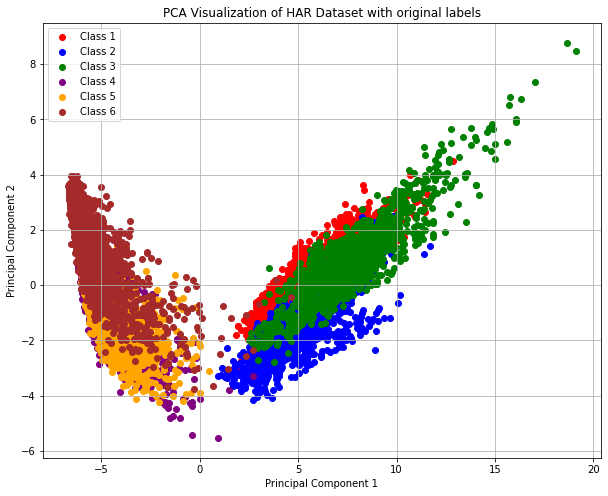

In [16]:
# Plot the PCA results
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']  # Colors for each class
for i, target in enumerate(np.unique(y_1)):
    plt.scatter(X_pca[y_1== target, 0], X_pca[y_1 == target, 1], c=colors[i], label=f"Class {target}")

#plt.scatter(X_pca[:, 0], X_pca[:, 1])    
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of HAR Dataset with original labels")
plt.legend()
plt.grid(True)
plt.show()

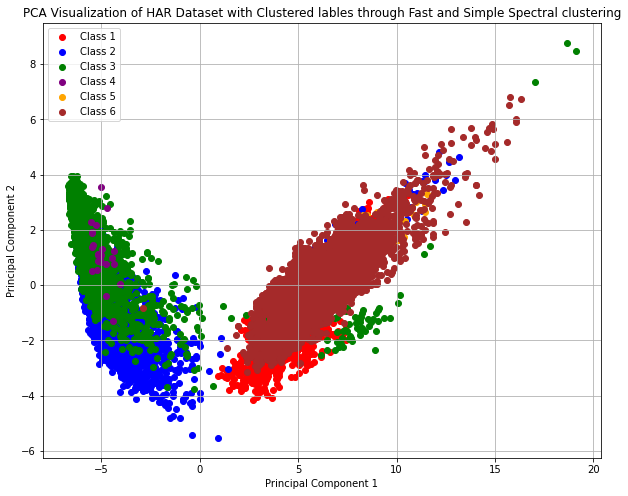

In [17]:
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']  # Colors for each class
for i, target in enumerate(np.unique(y_pred_1)):
    plt.scatter(X_pca[y_pred_1== target, 0], X_pca[y_pred_1 == target, 1], c=colors[i], label=f"Class {target}")

#plt.scatter(X_pca[:, 0], X_pca[:, 1])    
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of HAR Dataset with Clustered lables through Fast and Simple Spectral clustering")
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# import matplotlib.pyplot as plt
# num_clusters=6
# # pca = PCA(n_components=2, random_state=42)
# # X_pca = pca.fit_transform(data)
# def figure_plot_spectral(x, p_ij, num_clusters, data):
#   colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'orange', 'purple', 'pink', 'brown', 'lime', 'teal', 'olive', 'navy']
#   plt.figure(figsize=(10, 8))
#   data1=np.array(data)
#   for i in range(num_clusters):
#     points = data1[p_ij == i]
#     # plt.scatter(points[:, 0], points[:, 1], s=50, c=colors[i], label=f'Cluster {i+1}')
#     plt.scatter(X_pca[:, 0], X_pca[:, 1], c=p_ij, cmap='viridis', s=40)
#   # plt.scatter(x[:, 0], x[:, 1], s=100, c='black', marker='*', label='Centroids')
#   plt.colorbar(label='Cluster')
#   plt.title('Fast Spectral Clustering')
#   plt.xlabel('Feature 1')
#   plt.ylabel('Feature 2')
#   plt.legend()
#   plt.grid(True)
#   return plt.show()

# figure_plot_spectral(clu_1, y_pred_1,num_clusters,data_1)

# Fast Spectral Clustering using distance as the criteria as the criteria for the K-nearest neighbors

In [18]:
def preprocess_openml_data_distance(dataset_name: str):
    # Load the dataset
    mnist = fetch_openml(dataset_name)
    replace_dict = {chr(i): i-96 for i in range(97, 107)}
    X = np.array(mnist.data.replace(replace_dict))
    target_to_label = {}
    gt_labels = []
    next_label = 0
    for l in list(mnist.target):
        if l not in target_to_label:
            target_to_label[l] = next_label
            next_label += 1
        gt_labels.append(target_to_label[l])
    
    # Create the k-nearest neighbors graph in 'distance' mode
    knn_graph = kneighbors_graph(X, n_neighbors=10, mode='distance', include_self=False)
    
    # Convert the graph to a lil_matrix
    distance_matrix = scipy.sparse.lil_matrix(knn_graph)
    
    # Make the matrix symmetric
    for i, j in zip(*distance_matrix.nonzero()):
        distance_matrix[j, i] = distance_matrix[i, j]  # Ensure the matrix is symmetric
    
    return distance_matrix, gt_labels


In [20]:
def main_program_fastd():
    mnist = fetch_openml('har')
    y=mnist.target
    start = time.time()
    adj,gt_labels=preprocess_openml_data_distance('har')
    g = stag.graph.Graph(adj)
    K=6
    y_pred,clu=fast_spectral_cluster(g,K)
    end=time.time()
    tot_time=end-start
    y_pred_adjusted = [label + 1 for label in y_pred]
    ari=adjusted_rand_score(y,y_pred_adjusted )
    nmi=normalized_mutual_info_score(y,y_pred_adjusted )
#     print("The adjusted_rand_score between the assigned clusters and the actual clusters: ")
#     print(ari)
#     print("The normalized_mutual_info_score between the assigned clusters and the actual clusters: ")
#     print(nmi)
    y1=y.tolist()
    y1=[int(num) for num in y1]
    return y_pred_adjusted,clu,mnist.data,y1,tot_time,ari,nmi

In [21]:
y_pred_2,clu_2,data_2,y_2,tot_time_2,ari_2,nmi_2=main_program_fastd()

In [23]:
print("The adjusted_rand_score between the assigned clusters and the actual clusters: ")
print(ari_2)
print("The normalized_mutual_info_score between the assigned clusters and the actual clusters: ")
print(nmi_2)

The adjusted_rand_score between the assigned clusters and the actual clusters: 
0.40131418251826434
The normalized_mutual_info_score between the assigned clusters and the actual clusters: 
0.5161058567517116


In [24]:
tot_time_2

16.097012042999268

In [91]:
# v=target_2.tolist()
# target_2=[int(num) for num in v]

In [25]:
pca = PCA(n_components=2, random_state=42)  # Choose 2 principal components for visualization
X_pca = pca.fit_transform(data_2)
X_pca=np.array(X_pca)

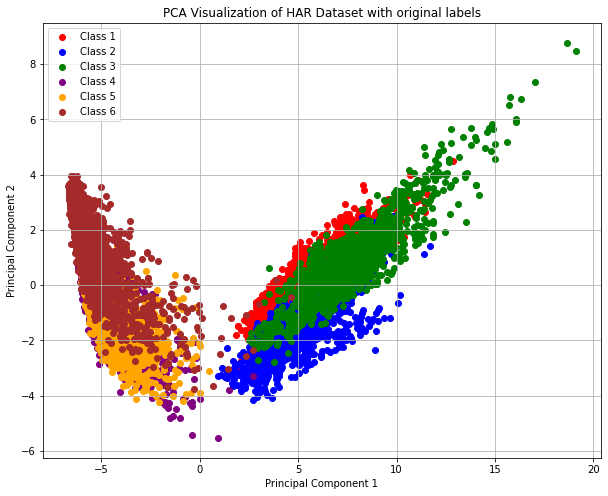

In [26]:
# Plot the PCA results
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']  # Colors for each class
for i, target in enumerate(np.unique(y_2)):
    plt.scatter(X_pca[y_2== target, 0], X_pca[y_2 == target, 1], c=colors[i], label=f"Class {target}")

#plt.scatter(X_pca[:, 0], X_pca[:, 1])    
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of HAR Dataset with original labels")
plt.legend()
plt.grid(True)
plt.show()

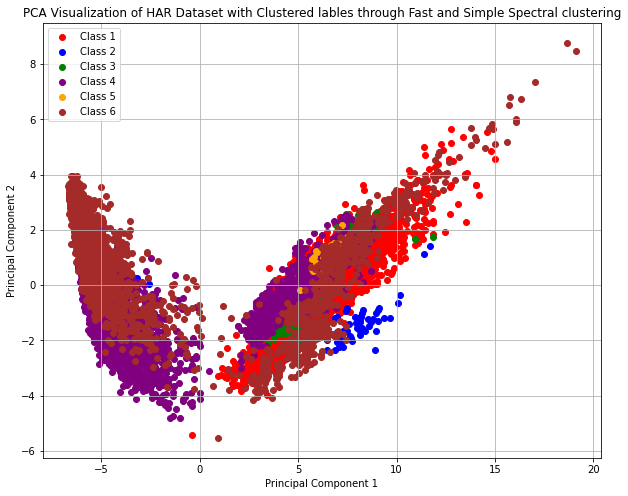

In [27]:
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']  # Colors for each class
for i, target in enumerate(np.unique(y_pred_2)):
    plt.scatter(X_pca[y_pred_2== target, 0], X_pca[y_pred_2 == target, 1], c=colors[i], label=f"Class {target}")

#plt.scatter(X_pca[:, 0], X_pca[:, 1])    
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of HAR Dataset with Clustered lables through Fast and Simple Spectral clustering")
plt.legend()
plt.grid(True)
plt.show()

# Classical Spectral Clustering using normalized Lapalacian matrix with the the Lloyd's algorithm

Using Connectivity as the criteria for the K-nearest neighbors

In [28]:
def spectral_cluster(g: stag.graph.Graph, k: int):
    lap_mat = g.normalised_laplacian()
    _, eigenvectors = scipy.sparse.linalg.eigsh(lap_mat, k, which='SM')
    labels,cluster_center = kmeans(eigenvectors, k)
    return labels,cluster_center

In [29]:
def main_program_classic_c():
    mnist = fetch_openml('har')
    y=mnist.target
    start=time.time()
    adj,gt_labels=preprocess_openml_data_connectivity('har')
    g = stag.graph.Graph(adj)
    K=6
    y_pred,clu=spectral_cluster(g,K)
    end=time.time()
    tot_time=end-start
    y_pred_adjusted = [label + 1 for label in y_pred]
    ari=adjusted_rand_score(y,y_pred_adjusted )
    nmi=normalized_mutual_info_score(y,y_pred_adjusted )
#     print("The adjusted_rand_score between the assigned clusters and the actual clusters: ")
#     print(ari)
#     print("The normalized_mutual_info_score between the assigned clusters and the actual clusters: ")
#     print(nmi)
    y1=y.tolist()
    y1=[int(num) for num in y1]
    return y_pred_adjusted,clu,mnist.data,y1,tot_time,ari,nmi

In [30]:
y_pred_3,clu_3,data_3,y_3,tot_time_3,ari_3,nmi_3=main_program_classic_c()

In [31]:
print("The adjusted_rand_score between the assigned clusters and the actual clusters: ")
print(ari_3)
print("The normalized_mutual_info_score between the assigned clusters and the actual clusters: ")
print(nmi_3)

The adjusted_rand_score between the assigned clusters and the actual clusters: 
0.513052428127109
The normalized_mutual_info_score between the assigned clusters and the actual clusters: 
0.6529800450429591


In [32]:
tot_time_3

21.61950159072876

In [33]:
pca = PCA(n_components=2, random_state=42)  # Choose 2 principal components for visualization
X_pca = pca.fit_transform(data_3)
X_pca=np.array(X_pca)

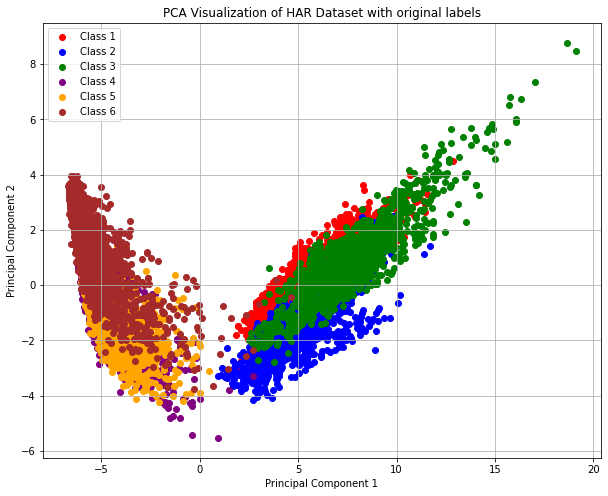

In [34]:
# Plot the PCA results
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']  # Colors for each class
for i, target in enumerate(np.unique(y_3)):
    plt.scatter(X_pca[y_3== target, 0], X_pca[y_3 == target, 1], c=colors[i], label=f"Class {target}")

#plt.scatter(X_pca[:, 0], X_pca[:, 1])    
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of HAR Dataset with original labels")
plt.legend()
plt.grid(True)
plt.show()

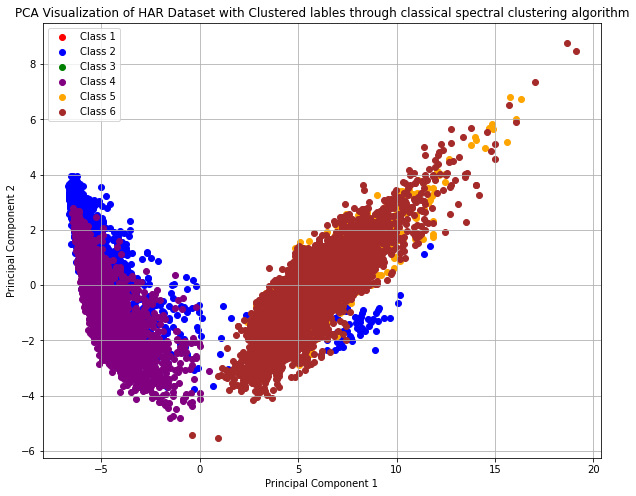

In [35]:
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']  # Colors for each class
for i, target in enumerate(np.unique(y_pred_3)):
    plt.scatter(X_pca[y_pred_3== target, 0], X_pca[y_pred_3 == target, 1], c=colors[i], label=f"Class {target}")

#plt.scatter(X_pca[:, 0], X_pca[:, 1])    
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of HAR Dataset with Clustered lables through classical spectral clustering algorithm")
plt.legend()
plt.grid(True)
plt.show()

Using distance as the criteria for the K-nearest neighbors

In [37]:
def main_program_classic_d():
    mnist = fetch_openml('har')
    y=mnist.target
    start=time.time()
    adj,gt_labels=preprocess_openml_data_distance('har')
    g = stag.graph.Graph(adj)
    K=6
    y_pred,clu=spectral_cluster(g,K)
    end=time.time()
    tot_time=end-start
    y_pred_adjusted = [label + 1 for label in y_pred]
    ari=adjusted_rand_score(y,y_pred_adjusted )
    nmi=normalized_mutual_info_score(y,y_pred_adjusted )
#     print("The adjusted_rand_score between the assigned clusters and the actual clusters: ")
#     print(ari)
#     print("The normalized_mutual_info_score between the assigned clusters and the actual clusters: ")
#     print(nmi)
    y1=y.tolist()
    y1=[int(num) for num in y1]
    return y_pred_adjusted,clu,mnist.data,y1,tot_time,ari,nmi

In [38]:
y_pred_4,clu_4,data_4,y_4,tot_time_4,ari_4,nmi_4=main_program_classic_d()

In [39]:
print("The adjusted_rand_score between the assigned clusters and the actual clusters: ")
print(ari_4)
print("The normalized_mutual_info_score between the assigned clusters and the actual clusters: ")
print(nmi_4)

The adjusted_rand_score between the assigned clusters and the actual clusters: 
0.4724847134037955
The normalized_mutual_info_score between the assigned clusters and the actual clusters: 
0.6823109070905495


In [40]:
tot_time_4

17.576104402542114

In [41]:
pca = PCA(n_components=2, random_state=42)  # Choose 2 principal components for visualization
X_pca = pca.fit_transform(data_4)
X_pca=np.array(X_pca)

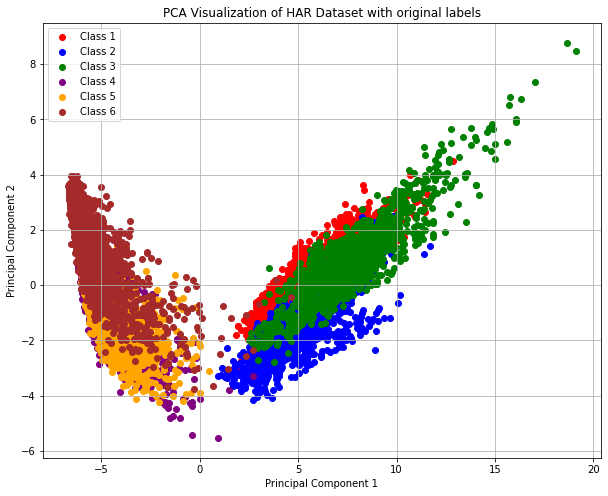

In [42]:
# Plot the PCA results
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']  # Colors for each class
for i, target in enumerate(np.unique(y_4)):
    plt.scatter(X_pca[y_4== target, 0], X_pca[y_4 == target, 1], c=colors[i], label=f"Class {target}")

#plt.scatter(X_pca[:, 0], X_pca[:, 1])    
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of HAR Dataset with original labels")
plt.legend()
plt.grid(True)
plt.show()

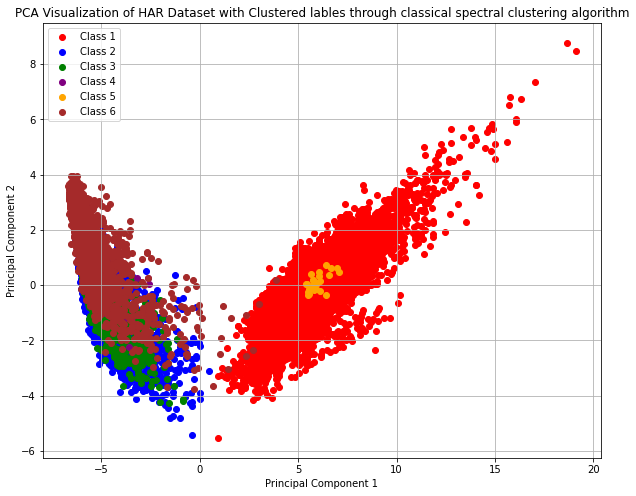

In [43]:
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']  # Colors for each class
for i, target in enumerate(np.unique(y_pred_4)):
    plt.scatter(X_pca[y_pred_4== target, 0], X_pca[y_pred_4 == target, 1], c=colors[i], label=f"Class {target}")

#plt.scatter(X_pca[:, 0], X_pca[:, 1])    
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of HAR Dataset with Clustered lables through classical spectral clustering algorithm")
plt.legend()
plt.grid(True)
plt.show()

Calculating the average_time, average ari,and average ami

In [44]:
functions = [main_program_fastc, main_program_fastd, main_program_classic_c,main_program_classic_d]

In [46]:
for func in functions:
    total_times = []
    aris = []
    nmis = []

    for _ in range(10):
        y_pred, clu, data, y, tot_time, ari, nmi = func()
        total_times.append(tot_time)
        aris.append(ari)
        nmis.append(nmi)

    # Compute the averages
    average_time = np.mean(total_times)
    average_ari = np.mean(aris)
    average_nmi = np.mean(nmis)

    # Print the results for each function
    print(f"Results for {func.__name__}:")
    print("Average Total Time:", average_time)
    print("Average ARI:", average_ari)
    print("Average NMI:", average_nmi)
    print("---------")


Results for main_program_fastc:
Average Total Time: 16.1241436958313
Average ARI: 0.36230508644687465
Average NMI: 0.4960793898930381
---------
Results for main_program_fastd:
Average Total Time: 16.062884974479676
Average ARI: 0.3571076531561054
Average NMI: 0.4942517223686824
---------
Results for main_program_classic_c:
Average Total Time: 16.958840894699097
Average ARI: 0.47726896950869657
Average NMI: 0.6838313621031317
---------
Results for main_program_classic_d:
Average Total Time: 16.748224782943726
Average ARI: 0.47451688631082967
Average NMI: 0.6796567746512323
---------
